---


**Machine Learning**

**Mohsen Iranmanesh**

**98155002**


---

# Importing MNIST Data 

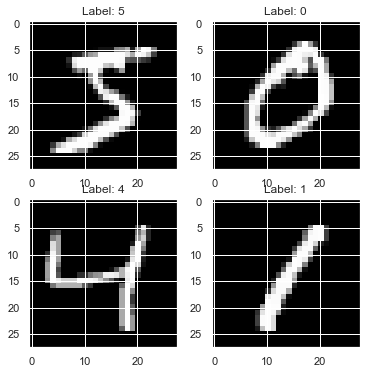

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [10]:
data = X_train[:15000]
labels = y_train[:15000]

print("The shape of sample data = ", data.shape)
print("The shape of sample labels = ", labels.shape)

The shape of sample data =  (15000, 784)
The shape of sample labels =  (15000,)


# Data-preprocessing: Standardizing the data

In [3]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)

(15000, 784)


# Finding Covariance Matrix

In [4]:
sample_data = standardized_data
covar_matrix = np.matmul(sample_data.T , sample_data)

# Finding eigen-values and eigen-vectors 

In [5]:
from scipy.linalg import eigh 

values, vectors = eigh(covar_matrix, eigvals=(782,783))
print("Shape of eigen vectors = ",vectors.shape)
vectors = vectors.T
print("Updated shape of eigen vectors = ",vectors.shape)

Shape of eigen vectors =  (784, 2)
Updated shape of eigen vectors =  (2, 784)


# Projecting the data

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

new_coordinates = np.matmul(vectors, sample_data.T)
new_coordinates = np.vstack((new_coordinates, labels)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st", "2nd", "label"))
print(dataframe.head())

   1st_principal  2nd_principal  label
0      -4.457050       0.960769    5.0
1      -7.397795      -8.658155    0.0
2       9.640690      -2.082854    4.0
3      -3.356074       7.187465    1.0
4       2.979880       4.933889    9.0


# Plot the projected Data

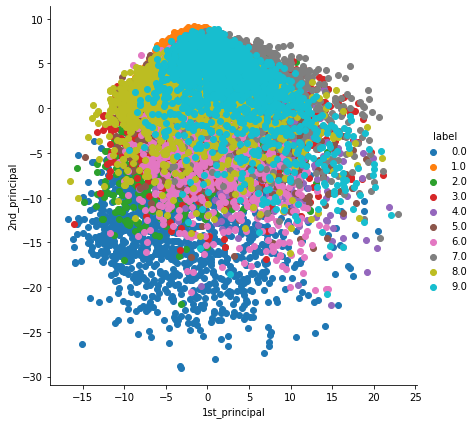

In [7]:
import seaborn as sn

sn.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

---


**As we saw, reducing the dimention to 2 is not capable of seperating the classes properly, and this is because PCA is performing the reduction based on just data variance in each class. The better way to do this dimension reduction can be performed by t-SNE which is based on the similarities. So we will first reduce the features from 784 to 50 with PCA and after that reduce the dimetion to 2 with the help of t-SNE**


---

# t-SNE

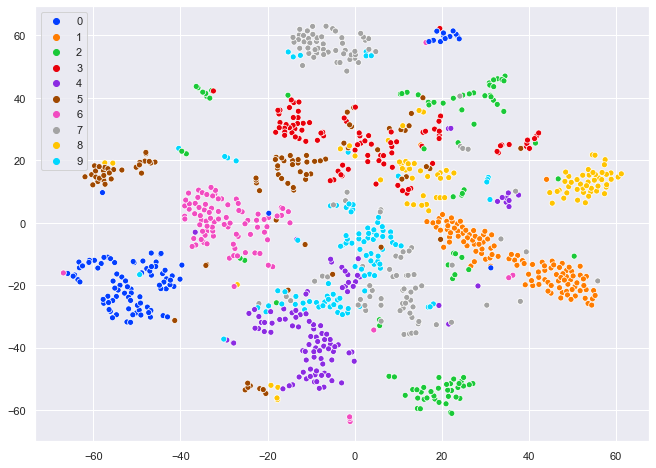

In [11]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy import linalg
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold.t_sne import _joint_probabilities
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(11,8)})
palette = sns.color_palette("bright", 10)

##########################

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

data = X_train[:1000]
label = y_train[:1000]

standardized_data = StandardScaler().fit_transform(data)

pca = decomposition.PCA()
pca.n_components = 50
X = pca.fit_transform(standardized_data)

##########################

MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30


def fit(X):
    n_samples = X.shape[0]
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    degrees_of_freedom = max(n_components - 1, 1)
    return tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)


def tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    obj_func = kl_divergence
    params = gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded


def kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'), X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad


def gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                     n_iter_check=1,
                     n_iter_without_progress=300,
                     momentum=0.8,
                     learning_rate=200.0,
                     min_gain=0.01,
                     min_grad_norm=1e-7):
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if grad_norm <= min_grad_norm:
            break
    return p

X_embedded = fit(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label, legend='full', palette=palette)